# Game Example

In [1]:
from maverick import Game, Player, ActionType, GameState, Street, PlayerLike
from maverick.players import FoldBot
import logging
from functools import partial
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)

# Get log messages only from the game
logging.getLogger().setLevel(logging.WARNING)  # Set root logger to WARNING
logging.getLogger("maverick").setLevel(logging.DEBUG)  # Only maverick logs at DEBUG

In [2]:
class CallBot(Player):
    """A passive bot that always calls or checks."""

    def decide_action(
        self,
        game_state: GameState,
        valid_actions: list[ActionType],
        min_raise: int
    ) -> tuple[ActionType, int]:
        """Always call or check if possible, otherwise fold."""
        if ActionType.CHECK in valid_actions:
            return (ActionType.CHECK, 0)
        elif ActionType.CALL in valid_actions:
            call_amount = game_state.current_bet - self.current_bet
            if call_amount <= self.stack:
                return (ActionType.CALL, call_amount)
        return (ActionType.FOLD, 0)

In [3]:
class AggressiveBot(Player):
    """An aggressive bot that frequently bets and raises."""

    def decide_action(
        self,
        game_state: GameState,
        valid_actions: list[ActionType],
        min_raise: int
    ) -> tuple[ActionType, int]:
        """Bet or raise aggressively."""
        # Try to raise if possible
        if ActionType.RAISE in valid_actions:
            raise_amount = min_raise
            if raise_amount <= self.stack:
                return (ActionType.RAISE, raise_amount)

        # Otherwise bet if possible
        if ActionType.BET in valid_actions:
            bet_amount = game_state.big_blind * 2
            if bet_amount <= self.stack:
                return (ActionType.BET, bet_amount)

        # Call if we can't bet/raise
        if ActionType.CALL in valid_actions:
            call_amount = game_state.current_bet - self.current_bet
            if call_amount <= self.stack:
                return (ActionType.CALL, call_amount)

        # Check if possible
        if ActionType.CHECK in valid_actions:
            return (ActionType.CHECK, 0)

        # Otherwise fold
        return (ActionType.FOLD, 0)

In [4]:
class SmartBot(Player):
    """A strategic bot that considers hand strength."""

    def decide_action(
        self,
        game_state: GameState,
        valid_actions: list[ActionType],
        min_raise: int
    ) -> tuple[ActionType, int]:
        """Make strategic decisions based on game state."""
        # Simple strategy: aggressive early, cautious later
        pot_size = game_state.pot

        # On pre-flop, be selective
        if game_state.street == Street.PRE_FLOP:
            if ActionType.CHECK in valid_actions:
                return (ActionType.CHECK, 0)
            elif ActionType.CALL in valid_actions:
                call_amount = game_state.current_bet - self.current_bet
                # Only call small bets pre-flop
                if call_amount <= game_state.big_blind * 3:
                    if call_amount <= self.stack:
                        return (ActionType.CALL, call_amount)
            return (ActionType.FOLD, 0)

        # Post-flop, consider pot size
        if ActionType.BET in valid_actions and pot_size < game_state.big_blind * 10:
            bet_amount = pot_size // 2
            if bet_amount <= self.stack and bet_amount >= game_state.min_bet:
                return (ActionType.BET, bet_amount)

        if ActionType.CHECK in valid_actions:
            return (ActionType.CHECK, 0)

        if ActionType.CALL in valid_actions:
            call_amount = game_state.current_bet - self.current_bet
            # Use pot odds to decide
            if call_amount <= pot_size // 3 and call_amount <= self.stack:
                return (ActionType.CALL, call_amount)

        return (ActionType.FOLD, 0)

In [5]:
# Create game with blinds
game = Game(small_blind=10, big_blind=20, max_hands=10)

# Create and add players with different strategies
players: list[PlayerLike] = [
    CallBot(id="p1", name="CallBot", stack=1000, seat=0),
    AggressiveBot(id="p2", name="AggroBot", stack=1000, seat=1),
    SmartBot(id="p3", name="SmartBot", stack=1000, seat=2),
    FoldBot(id="p4", name="FoldBot", stack=1000, seat=3),
]

for player in players:
    game.add_player(player)
    
game.start()

2026-01-09 17:06:49,852 [INFO] maverick: Player CallBot joined the game.
2026-01-09 17:06:49,853 [INFO] maverick: Player AggroBot joined the game.
2026-01-09 17:06:49,853 [INFO] maverick: Player SmartBot joined the game.
2026-01-09 17:06:49,854 [INFO] maverick: Player FoldBot joined the game.
2026-01-09 17:06:49,855 [INFO] maverick: Game started.

2026-01-09 17:06:49,855 [INFO] maverick: ============================== Hand 1 ==============================

2026-01-09 17:06:49,856 [INFO] maverick: PRE_FLOP | Dealing hole cards. Dealer: CallBot
2026-01-09 17:06:49,857 [INFO] maverick: PRE_FLOP | Posting small blind of 10 by player AggroBot. Remaining stack: 990
2026-01-09 17:06:49,857 [INFO] maverick: PRE_FLOP | Posting big blind of 20 by player SmartBot. Remaining stack: 980
2026-01-09 17:06:49,857 [INFO] maverick: PRE_FLOP | Player FoldBot folds.
2026-01-09 17:06:49,857 [INFO] maverick: PRE_FLOP | Current pot: 30
2026-01-09 17:06:49,857 [INFO] maverick: PRE_FLOP | Player CallBot calls 

You can print the final stacks of the players using the original list of players:

In [6]:
for player in players:
    print(f"{player.name} - Stack: {player.stack}")

CallBot - Stack: 870
AggroBot - Stack: 1830
SmartBot - Stack: 380
FoldBot - Stack: 920


You can also use the state for this, but be aware that it only includes players who actually have some stack. If a player got eliminated, it wont apper in the following listing.

In [7]:
for player in game.state.players:
    print(f"{player.name} - Stack: {player.stack}")

CallBot - Stack: 870
AggroBot - Stack: 1830
SmartBot - Stack: 380
FoldBot - Stack: 920


## Find the best player

We are going to find the best player by playing lots of games with the same players as before and calculating their average payoff.

For this, we first need to wrap up the game in a function that we can call in a loop.

In [8]:
# We don't want too much logging output for this example
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
)
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger("maverick").setLevel(logging.WARNING)


# Function to play a game with specified parameters
def play_game(
    small_blind:int=10, 
    big_blind:int=20, 
    max_hands:int=40,
    initial_stack:int=1000
) -> tuple[list[PlayerLike],Game]:
    game = Game(small_blind=small_blind, big_blind=big_blind, max_hands=max_hands)

    players: list[PlayerLike] = [
        CallBot(id="p1", name="CallBot", stack=initial_stack, seat=0),
        AggressiveBot(id="p2", name="AggroBot", stack=initial_stack, seat=1),
        SmartBot(id="p3", name="SmartBot", stack=initial_stack, seat=2),
        FoldBot(id="p4", name="FoldBot", stack=initial_stack, seat=3),
    ]

    for player in players:
        game.add_player(player)
        
    game.start()
    
    return players, game


# Play a single game
players, game = play_game(small_blind=10, big_blind=20, max_hands=10, initial_stack=1000)

# Print final stacks
for player in players:
    print(f"{player.name} - Stack: {player.stack}")

CallBot - Stack: 0
AggroBot - Stack: 1300
SmartBot - Stack: 1790
FoldBot - Stack: 910


Now play a bunch of games and visualize average payoffs. Here we define payoff as the final stock minus the initial stack. This means that the payoff can be negative. The reason behind this choice is that this gives a more intuitive visual representation (look at the FoldBot).

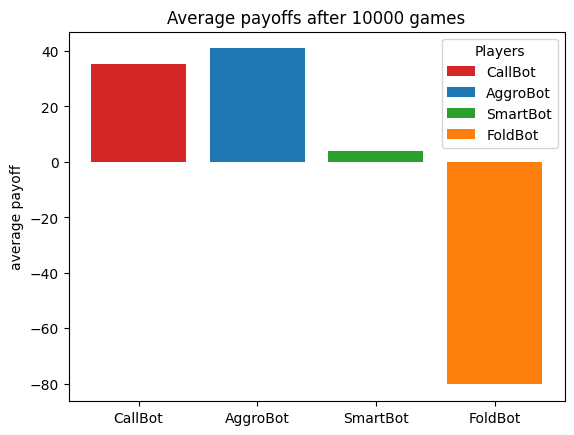

In [9]:
# Start with a smaller number (like 100) to get a feel of execution time,
# then you can move to higher numbers like 10_000 for a more confident estimation.
n_game = 10_000

# Define game parameters
small_blind=10
big_blind=20
max_hands=10
initial_stack=1000

# Create helper function with fixed parameters
play = partial(
    play_game, 
    small_blind=small_blind, 
    big_blind=big_blind, 
    max_hands=max_hands, 
    initial_stack=initial_stack
)

# Collect results
results = {p.name : [] for p in players}
for _ in range(n_game):
    players, game = play()
    for player in players:
        results[player.name].append(player.stack - initial_stack)

# Compute average payoffs    
average_payoffs = {name: sum(payoffs)/n_game for name, payoffs in results.items()}

# --------------------------------- Plotting ---------------------------------

fig, ax = plt.subplots()

names = []
avg_payoffs = []
for name, avg_payoff in average_payoffs.items():
    names.append(name)
    avg_payoffs.append(avg_payoff)
    
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
ax.bar(names, avg_payoffs, label=names, color=bar_colors)

ax.set_ylabel('average payoff')
ax.set_title(f'Average payoffs after {n_game} games')
ax.legend(title='Players')

plt.show()

### Findings

Here are my findings about kicking off the previous cell a number of times:

1) SmartBot is actually pretty dumb on average.
2) AggroBot is typically the best performer among these players.
3) CallBot usually beats SmartBot.
4) FoldBot is a good strategy if you like to loose.